## Project Group 1; Naeim's crude code

### Setting up a Spark Session to work with structured data

In [1]:
from pyspark.sql import SparkSession
# import pandas as pd

In [2]:
# To run the code on local machine or on server
server_mode = False

In [3]:
if server_mode:
    #New API
    spark_session = SparkSession\
            .builder\
            .master("spark://192.168.2.74:7077") \
            .appName("Project_G1_Naeim")\
            .config("spark.dynamicAllocation.enabled", True)\
            .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
            .config("spark.shuffle.service.enabled", False)\
            .config("spark.dynamicAllocation.executorIdleTimeout","300s")\
            .config("spark.executor.cores",1)\
            .config("spark.driver.port",9998)\
            .config("spark.blockManager.port",10005)\
            .getOrCreate()

    # Old API (RDD)
    spark_context = spark_session.sparkContext
    spark_context.setLogLevel("ERROR")
    # spark_context.setLogLevel("INFO")
    
else:
    # local version, deactivate later!
    spark_session = SparkSession.builder.appName('Project_G1').getOrCreate()

22/03/16 00:15:01 WARN Utils: Your hostname, nanook resolves to a loopback address: 127.0.1.1; using 192.168.1.69 instead (on interface enp5s0)
22/03/16 00:15:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/16 00:15:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark_session # to get some info about the Session

### Check the existing source files and their names in the remote directories before downloading them

In [5]:
from bs4 import BeautifulSoup
import os
import requests

urls = ['https://github.com/fivethirtyeight/uber-tlc-foil-response/blob/master/uber-trip-data/',
        'https://github.com/fivethirtyeight/uber-tlc-foil-response/blob/master/other-FHV-data/',
        'https://github.com/fivethirtyeight/uber-tlc-foil-response/']

exts = ['csv'] #, 'xlsx'

def get_content(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
file_names = []

for url in urls:
    for ext in exts:
        for file in get_content(url, ext):
            file_names.append(os.path.basename(file))

print(f'Number of files with csv extension: {len(file_names)}')
print(file_names[:5])

Number of files with csv extension: 19
['taxi-zone-lookup.csv', 'uber-raw-data-apr14.csv', 'uber-raw-data-aug14.csv', 'uber-raw-data-jul14.csv', 'uber-raw-data-jun14.csv']


### Download source files in local file system before working with Spark

In [6]:
# !pip install gitpython
from git import Repo
if not os.path.isdir('DATA') or len(os.listdir('DATA')) == 0:
    git_url = 'https://github.com/fivethirtyeight/uber-tlc-foil-response.git'
    Repo.clone_from(git_url, 'Git_repo');
    print('The repository is downloaded!')
else:
    print('The repository is ALREADY downloaded!')

The repository is ALREADY downloaded!


### Keeping useful files from git repository

In [7]:
import os
import shutil

src = r'Git_repo'
if os.path.isdir('Git_repo'):
    os.system("rm -rf DATA")
    os.makedirs('DATA')
    print("Old DATA directory deleted!")
    dest = r'DATA'

    for path, subdirs, files in os.walk(src):
        if '.git' in subdirs:
            subdirs.remove('.git')
        for name in files:
            if name.endswith('.csv'): # or name.endswith('.xlsx'):
                filename = os.path.join(path, name)
                shutil.copy2(filename, dest)
else:
    print(f"{exts} files already extracted!")

if os.path.isdir('DATA'):
    path = os.getcwd() + '/DATA'
    list_dir = os.listdir(path)
    count = 0
    for file in list_dir:
        if file.endswith(exts[0]):
            count += 1
    print(f"Number of new {exts} extracted files: {count}")
os.system("rm -rf Git_repo");

['csv'] files already extracted!
Number of new ['csv'] extracted files: 19


### Load the CSV files from source folder, and call show() to verify the data is loaded to RAM correctly

In [8]:
# Laodig data in Spark & writing in HDFS
df_list = {}
for file in file_names:
    # spark_file = 'df_'+ (os.path.splitext(file)[0]).split('-')[-1]
    # df_list[file] = spark_session.read.csv('DATA/'+file, header=True, inferSchema=True)
    df_list[file] = spark_session.read.option("header","true").csv('DATA/'+file)

# df_list.items()

In [9]:
import pyspark.sql
if df_list[file_names[0]] is not None and \
                isinstance(df_list[file_names[0]], \
                    pyspark.sql.dataframe.DataFrame):
    print("Spark dataframe exists")

Spark dataframe exists


In [10]:
file_names[0], type(df_list[file_names[0]])

('taxi-zone-lookup.csv', pyspark.sql.dataframe.DataFrame)

In [11]:
df_list[file_names[0]].show(2)

+----------+-------+--------------+
|LocationID|Borough|          Zone|
+----------+-------+--------------+
|         1|    EWR|Newark Airport|
|         2| Queens|   Jamaica Bay|
+----------+-------+--------------+
only showing top 2 rows



In [12]:
df_list[file_names[0]].printSchema()

root
 |-- LocationID: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)



### Pre-processing (Null values, Seperating date and time, Unified dataframe for related data)

In [13]:
# The code is inspired by 'pault' @ stackoverflow
# Pyspark - Calculate number of null values in each dataframe column

import pyspark.sql.functions as func
from functools import reduce

def count_null_values_in_df(any_df):
    
    df_agg = any_df.agg(*[func.count(func.when(func.isnull(c), c)).alias(c) for c in any_df.columns])
    null_table = reduce(lambda a, b: a.union(b),(
        df_agg.select(func.lit(c).alias("Column"), func.col(c).alias("Nbr of Null")) 
        for c in df_agg.columns))
    
    null_table.show()
    print(f'Initial number of rows: {any_df.count()}')
    print("************\n")
    
    any_df = any_df.na.drop(how='all') # to drop any row with all values as Null

In [14]:
x = 1
for key in df_list.keys():
    if 'uber-raw-data' in key:
        print(f'{x}: {key}')
        count_null_values_in_df(df_list[key])   
        x += 1

1: uber-raw-data-apr14.csv


+---------+-----------+
|   Column|Nbr of Null|
+---------+-----------+
|Date/Time|          0|
|      Lat|          0|
|      Lon|          0|
|     Base|          0|
+---------+-----------+

Initial number of rows: 564516
************

2: uber-raw-data-aug14.csv


+---------+-----------+
|   Column|Nbr of Null|
+---------+-----------+
|Date/Time|          0|
|      Lat|          0|
|      Lon|          0|
|     Base|          0|
+---------+-----------+

Initial number of rows: 829275
************

3: uber-raw-data-jul14.csv


+---------+-----------+
|   Column|Nbr of Null|
+---------+-----------+
|Date/Time|          0|
|      Lat|          0|
|      Lon|          0|
|     Base|          0|
+---------+-----------+

Initial number of rows: 796121
************

4: uber-raw-data-jun14.csv


+---------+-----------+
|   Column|Nbr of Null|
+---------+-----------+
|Date/Time|          0|
|      Lat|          0|
|      Lon|          0|
|     Base|          0|
+---------+-----------+

Initial number of rows: 663844
************

5: uber-raw-data-may14.csv


+---------+-----------+
|   Column|Nbr of Null|
+---------+-----------+
|Date/Time|          0|
|      Lat|          0|
|      Lon|          0|
|     Base|          0|
+---------+-----------+

Initial number of rows: 652435
************

6: uber-raw-data-sep14.csv


+---------+-----------+
|   Column|Nbr of Null|
+---------+-----------+
|Date/Time|          0|
|      Lat|          0|
|      Lon|          0|
|     Base|          0|
+---------+-----------+

Initial number of rows: 1028136
************



### Preparing Uber raw data
Uber data (4.5 million Uber pickups in New York City from April to September 2014, and 14.3 million more Uber pickups from January to June 2015)

In [15]:
col_names = df_list['uber-raw-data-apr14.csv'].schema.names
col_names

['Date/Time', 'Lat', 'Lon', 'Base']

In [16]:
from pyspark.sql.types import StructType, StructField, StringType
sc = spark_session.sparkContext

col_names = df_list['uber-raw-data-apr14.csv'].schema.names
mySchema = StructType([StructField(c, StringType()) for c in col_names])
uber_raw_data = SparkSession(sc).createDataFrame(data=[], schema=mySchema)
uber_raw_data.show()

+---------+---+---+----+
|Date/Time|Lat|Lon|Base|
+---------+---+---+----+
+---------+---+---+----+



In [17]:
manual_rows = 0
number_of_files = 0
for key in df_list.keys():
    if 'uber-raw-data' in key:
        uber_raw_data = uber_raw_data.union(df_list[key])
        manual_rows += df_list[key].count()
        number_of_files += 1

print(f"Total number of files combined: {number_of_files}")
print(f'Total number of rows in unified dataframe: {manual_rows}')

Total number of files combined: 6
Total number of rows in unified dataframe: 4534327


In [18]:
if (uber_raw_data.count() == manual_rows):
    print("The number of rows match in the unified file!")

The number of rows match in the unified file!


In [19]:
if server_mode:
    path = 'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data'
else:
    path = os.getcwd() + '/DATA/'

uber_unified_file = path+"uber_raw_data.parquet"
uber_raw_data.write.mode("overwrite").parquet(uber_unified_file)

### To check if downloaded files exists in HDFS system

In [20]:
fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(sc._jsc.hadoopConfiguration())
if server_mode:
    path = 'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/'
else:
    path = os.getcwd() + '/DATA/'

path = path + 'uber_raw_data.parquet'
print(fs.exists(sc._jvm.org.apache.hadoop.fs.Path(path)))

True


## To read parquet file use the code below

In [21]:
uber_raw_data_read_test = spark_session.read.parquet(uber_unified_file)
uber_raw_data_read_test.printSchema()
uber_raw_data_read_test.show(3)
uber_raw_data.count()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: string (nullable = true)
 |-- Lon: string (nullable = true)
 |-- Base: string (nullable = true)

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|9/1/2014 0:01:00|40.2201|-74.0021|B02512|
|9/1/2014 0:01:00|  40.75|-74.0027|B02512|
|9/1/2014 0:03:00|40.7559|-73.9864|B02512|
+----------------+-------+--------+------+
only showing top 3 rows



4534327

### Preparing For-Hire Vehicle (FHV) data
FHV companies (10 files of raw data on pickups from 10 FHV companies. The trip information varies by company, but can include day of trip, time of trip, pickup location, driver's for-hire license number, and vehicle's for-hire license number.)

#### Drop Null columns manually for each dataframe

In [22]:
x = 1
for key in df_list.keys():
    if 'uber-raw-data' not in key:
        print(f'{x}: {key}')
        print(df_list[key].dtypes)
        count_null_values_in_df(df_list[key]) 
        x += 1

1: taxi-zone-lookup.csv
[('LocationID', 'string'), ('Borough', 'string'), ('Zone', 'string')]
+----------+-----------+
|    Column|Nbr of Null|
+----------+-----------+
|LocationID|          0|
|   Borough|          0|
|      Zone|          0|
+----------+-----------+

Initial number of rows: 265
************

2: American_B01362.csv
[('DATE', 'string'), ('TIME', 'string'), ('PICK UP ADDRESS', 'string'), ('_c3', 'string'), ('_c4', 'string'), ('_c5', 'string')]


22/03/16 00:16:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c3
Expected: _c3 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/American_B01362.csv
22/03/16 00:16:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c4
Expected: _c4 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/American_B01362.csv
22/03/16 00:16:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c5
Expected: _c5 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/American_B01362.csv


+---------------+-----------+
|         Column|Nbr of Null|
+---------------+-----------+
|           DATE|          0|
|           TIME|          0|
|PICK UP ADDRESS|          0|
|            _c3|      91712|
|            _c4|      91712|
|            _c5|      91712|
+---------------+-----------+

Initial number of rows: 91712
************

3: Carmel_B00256.csv
[('Date', 'string'), ('Time', 'string'), ('PU_Adress', 'string'), ('Base_No', 'string')]


+---------+-----------+
|   Column|Nbr of Null|
+---------+-----------+
|     Date|          0|
|     Time|          0|
|PU_Adress|          0|
|  Base_No|          0|
+---------+-----------+

Initial number of rows: 256519
************

4: Dial7_B00887.csv
[('Date', 'string'), ('Time', 'string'), ('State', 'string'), ('PuFrom', 'string'), ('Address', 'string'), ('Street', 'string')]


+-------+-----------+
| Column|Nbr of Null|
+-------+-----------+
|   Date|          0|
|   Time|          0|
|  State|          0|
| PuFrom|      37030|
|Address|          0|
| Street|          0|
+-------+-----------+

Initial number of rows: 194992
************

5: Diplo_B01196.csv
[('Date', 'string'), ('Time', 'string'), ('PU_Address', 'string')]


+----------+-----------+
|    Column|Nbr of Null|
+----------+-----------+
|      Date|          0|
|      Time|          0|
|PU_Address|          0|
+----------+-----------+

Initial number of rows: 98550
************

6: Federal_02216.csv
[('Date', 'string'), ('Time', 'string'), ('PU_Address2', 'string'), ('DO_Address', 'string'), ('Routing Details', 'string'), ('PU_Address5', 'string'), ('Status', 'string')]


22/03/16 00:16:42 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: PU_Address
 Schema: PU_Address2
Expected: PU_Address2 but found: PU_Address
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Federal_02216.csv
22/03/16 00:16:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: PU_Address
 Schema: PU_Address5
Expected: PU_Address5 but found: PU_Address
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Federal_02216.csv


+---------------+-----------+
|         Column|Nbr of Null|
+---------------+-----------+
|           Date|          0|
|           Time|          0|
|    PU_Address2|          7|
|     DO_Address|          9|
|Routing Details|          0|
|    PU_Address5|          0|
|         Status|          0|
+---------------+-----------+

Initial number of rows: 276
************

7: Firstclass_B01536.csv
[('DATE', 'string'), ('TIME', 'string'), ('PICK UP ADDRESS', 'string')]


+---------------+-----------+
|         Column|Nbr of Null|
+---------------+-----------+
|           DATE|          0|
|           TIME|          0|
|PICK UP ADDRESS|          0|
+---------------+-----------+

Initial number of rows: 166769
************

8: Highclass_B01717.csv
[('DATE', 'string'), ('TIME', 'string'), ('PU_Address', 'string')]


+----------+-----------+
|    Column|Nbr of Null|
+----------+-----------+
|      DATE|          0|
|      TIME|          0|
|PU_Address|          0|
+----------+-----------+

Initial number of rows: 151925
************

9: Lyft_B02510.csv
[('time_of_trip', 'string'), ('start_lat', 'string'), ('start_lng', 'string'), ('_c3', 'string')]


22/03/16 00:16:48 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c3
Expected: _c3 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Lyft_B02510.csv


+------------+-----------+
|      Column|Nbr of Null|
+------------+-----------+
|time_of_trip|          0|
|   start_lat|          1|
|   start_lng|          1|
|         _c3|     266503|
+------------+-----------+

Initial number of rows: 267701
************

10: Prestige_B01338.csv
[('DATE', 'string'), ('TIME', 'string'), ('PICK UP ADDRESS', 'string')]


+---------------+-----------+
|         Column|Nbr of Null|
+---------------+-----------+
|           DATE|          0|
|           TIME|          0|
|PICK UP ADDRESS|          0|
+---------------+-----------+

Initial number of rows: 320641
************

11: Skyline_B00111.csv
[('Date', 'string'), ('Time', 'string'), ('    Street_Address ', 'string'), ('    City_State ', 'string'), ('_c4', 'string'), ('_c5', 'string')]


22/03/16 00:16:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c4
Expected: _c4 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Skyline_B00111.csv
22/03/16 00:16:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c5
Expected: _c5 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Skyline_B00111.csv


+-------------------+-----------+
|             Column|Nbr of Null|
+-------------------+-----------+
|               Date|          0|
|               Time|          0|
|    Street_Address |          0|
|        City_State |          0|
|                _c4|     127696|
|                _c5|     127696|
+-------------------+-----------+



Initial number of rows: 127696
************

12: other-FHV-data-jan-aug-2015.csv
[('_c0', 'string'), ('_c1', 'string'), ('_c2', 'string'), ('_c3', 'string'), ('_c4', 'string'), ('_c5', 'string'), ('_c6', 'string')]


22/03/16 00:16:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c0
Expected: _c0 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/other-FHV-data-jan-aug-2015.csv
22/03/16 00:16:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c1
Expected: _c1 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/other-FHV-data-jan-aug-2015.csv
22/03/16 00:16:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c2
Expected: _c2 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/other-FHV-data-jan-aug-2015.csv
22/03/16 00:16:55 WARN CSVHeaderChecker: CSV header does not confor

+------+-----------+
|Column|Nbr of Null|
+------+-----------+
|   _c0|      26186|
|   _c1|          5|
|   _c2|          5|
|   _c3|      26187|
|   _c4|          5|
|   _c5|          5|
|   _c6|          5|
+------+-----------+

Initial number of rows: 26187
************

13: Uber-Jan-Feb-FOIL.csv
[('dispatching_base_number', 'string'), ('date', 'string'), ('active_vehicles', 'string'), ('trips', 'string')]
+--------------------+-----------+
|              Column|Nbr of Null|
+--------------------+-----------+
|dispatching_base_...|          0|
|                date|          0|
|     active_vehicles|          0|
|               trips|          0|
+--------------------+-----------+

Initial number of rows: 354
************



In [23]:
df_list['Dial7_B00887.csv'].select('PuFrom').show(10)
df_list['Dial7_B00887.csv'] = df_list['Dial7_B00887.csv']\
                        .na.fill('UNKOWN')
df_list['Dial7_B00887.csv'].filter(df_list['Dial7_B00887.csv']\
                        .PuFrom.isNull()).count()

+---------+
|   PuFrom|
+---------+
|MANHATTAN|
|MANHATTAN|
|MANHATTAN|
|MANHATTAN|
|MANHATTAN|
|MANHATTAN|
|MANHATTAN|
|MANHATTAN|
|   QUEENS|
|MANHATTAN|
+---------+
only showing top 10 rows



0

In [24]:
df_list['American_B01362.csv'].show(5)
columns_to_drop = ['_c3','_c4','_c5']
df_list['American_B01362.csv'] = \
    df_list['American_B01362.csv'].drop(*columns_to_drop)
df_list['American_B01362.csv'].show(2)

+--------+-----------+--------------------+----+----+----+
|    DATE|       TIME|     PICK UP ADDRESS| _c3| _c4| _c5|
+--------+-----------+--------------------+----+----+----+
|7/1/2014|12:00:00 AM| 874 E 139th St M...|null|null|null|
|7/1/2014|12:01:00 AM| 628 E 141st St M...|null|null|null|
|7/1/2014|12:01:00 AM| 601 E 156th St S...|null|null|null|
|7/1/2014|12:01:00 AM| 708 E 138th St M...|null|null|null|
|7/1/2014|12:02:00 AM| 700 E 140th St M...|null|null|null|
+--------+-----------+--------------------+----+----+----+
only showing top 5 rows

+--------+-----------+--------------------+
|    DATE|       TIME|     PICK UP ADDRESS|
+--------+-----------+--------------------+
|7/1/2014|12:00:00 AM| 874 E 139th St M...|
|7/1/2014|12:01:00 AM| 628 E 141st St M...|
+--------+-----------+--------------------+
only showing top 2 rows



22/03/16 00:16:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: DATE, TIME, PICK UP ADDRESS, , , 
 Schema: DATE, TIME, PICK UP ADDRESS, _c3, _c4, _c5
Expected: _c3 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/American_B01362.csv


In [25]:
df_list['Lyft_B02510.csv'].show(2)
df_list['Lyft_B02510.csv'] = \
    df_list['Lyft_B02510.csv'].drop('_c3')
df_list['Lyft_B02510.csv'].show(2)

22/03/16 00:16:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: time_of_trip, start_lat, start_lng, 
 Schema: time_of_trip, start_lat, start_lng, _c3
Expected: _c3 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Lyft_B02510.csv


+---------------+---------+---------+----+
|   time_of_trip|start_lat|start_lng| _c3|
+---------------+---------+---------+----+
|  9/4/2014 9:51| 40.64705|-73.77988|null|
|8/27/2014 21:13| 40.74916|-73.98373|null|
+---------------+---------+---------+----+
only showing top 2 rows

+---------------+---------+---------+
|   time_of_trip|start_lat|start_lng|
+---------------+---------+---------+
|  9/4/2014 9:51| 40.64705|-73.77988|
|8/27/2014 21:13| 40.74916|-73.98373|
+---------------+---------+---------+
only showing top 2 rows



In [26]:
df_list['Skyline_B00111.csv'].show(2)
df_list['Skyline_B00111.csv'] = \
    df_list['Skyline_B00111.csv'].drop(*columns_to_drop)
df_list['Skyline_B00111.csv'].show(2)

+--------+--------------+--------------------+--------------------+----+----+
|    Date|          Time|     Street_Address |         City_State | _c4| _c5|
+--------+--------------+--------------------+--------------------+----+----+
|7/1/2014|    20:27     |    622 THIRD AV ...|     M           ...|null|null|
|7/1/2014|    21:04     |     E 77TH ST   ...|     M           ...|null|null|
+--------+--------------+--------------------+--------------------+----+----+
only showing top 2 rows

+--------+--------------+--------------------+--------------------+
|    Date|          Time|     Street_Address |         City_State |
+--------+--------------+--------------------+--------------------+
|7/1/2014|    20:27     |    622 THIRD AV ...|     M           ...|
|7/1/2014|    21:04     |     E 77TH ST   ...|     M           ...|
+--------+--------------+--------------------+--------------------+
only showing top 2 rows



22/03/16 00:16:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Time,     Street_Address ,     City_State , , 
 Schema: Date, Time,     Street_Address ,     City_State , _c4, _c5
Expected: _c4 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Skyline_B00111.csv


In [27]:
columns_to_drop = ['_c0','_c3']
df_list['other-FHV-data-jan-aug-2015.csv'] = \
    df_list['other-FHV-data-jan-aug-2015.csv'].drop(*columns_to_drop)
df_list['other-FHV-data-jan-aug-2015.csv'] = \
    df_list['other-FHV-data-jan-aug-2015.csv'].na.drop(how='all')

In [28]:
df_list['other-FHV-data-jan-aug-2015.csv'].show(1)

+-----------+---------+------------+---------------+------------------+
|        _c1|      _c2|         _c4|            _c5|               _c6|
+-----------+---------+------------+---------------+------------------+
|Base Number|Base Name|Pick Up Date|Number of Trips|Number of Vehicles|
+-----------+---------+------------+---------------+------------------+
only showing top 1 row



22/03/16 00:16:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , , , , 
 Schema: _c1, _c2, _c4, _c5, _c6
Expected: _c1 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/other-FHV-data-jan-aug-2015.csv


In [29]:
df_list['other-FHV-data-jan-aug-2015.csv'] = \
        df_list['other-FHV-data-jan-aug-2015.csv'].withColumnRenamed("_c1", "Base_Number")\
       .withColumnRenamed("_c2", "Base_Name").withColumnRenamed("_c4", "Pick_Up_Date")\
       .withColumnRenamed("_c5", "Number_of_Trips").withColumnRenamed("_c6", "Number_of_Vehicles")

df_list['other-FHV-data-jan-aug-2015.csv'] = \
        SparkSession(sc).createDataFrame(df_list['other-FHV-data-jan-aug-2015.csv']\
                              .tail(df_list['other-FHV-data-jan-aug-2015.csv'].count()-1)\
                              ,df_list['other-FHV-data-jan-aug-2015.csv'].schema)

df_list['other-FHV-data-jan-aug-2015.csv'].show(10)

22/03/16 00:16:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , , , , 
 Schema: _c1, _c2, _c4, _c5, _c6
Expected: _c1 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/other-FHV-data-jan-aug-2015.csv
22/03/16 00:16:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , , , , 
 Schema: _c1, _c2, _c4, _c5, _c6
Expected: _c1 but found: 
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/other-FHV-data-jan-aug-2015.csv


+-----------+--------------------+------------+---------------+------------------+
|Base_Number|           Base_Name|Pick_Up_Date|Number_of_Trips|Number_of_Vehicles|
+-----------+--------------------+------------+---------------+------------------+
|     B00013|   LOVE CORP CAR INC|  01/01/2015|            26 |               17 |
|     B00014| NY ONE CORP CAR INC|  01/01/2015|            45 |               24 |
|     B00029|COMMUNITY CAR SVC...|  01/01/2015|           731 |               36 |
|     B00053| CHARGE AND RIDE INC|  01/01/2015|            10 |                9 |
|     B00095|LIBERTY CAR SERVI...|  01/01/2015|           814 |               62 |
|     B00221|PROFESSIONAL CAR ...|  01/01/2015|           220 |               46 |
|     B00227|PARK WEST EXEC. S...|  01/01/2015|            36 |               28 |
|     B00248|YELLOWSTONE TRANS...|  01/01/2015|         1,137 |              106 |
|     B00254|   XYZ TWO WAY RADIO|  01/01/2015|           236 |              103 |
|   

In [30]:
df_list['Lyft_B02510.csv'] = df_list['Lyft_B02510.csv'].na.drop()
df_list['Federal_02216.csv'] = df_list['Federal_02216.csv']\
                        .na.fill('UNKOWN')

df_list['American_B01362.csv'] = \
        df_list['American_B01362.csv'].withColumnRenamed("PICK UP ADDRESS", "PICK_UP_ADDRESS")
df_list['Prestige_B01338.csv'] = \
        df_list['Prestige_B01338.csv'].withColumnRenamed("PICK UP ADDRESS", "PICK_UP_ADDRESS")

df_list['Firstclass_B01536.csv'] = \
        df_list['Firstclass_B01536.csv'].withColumnRenamed("PICK UP ADDRESS", "PICK_UP_ADDRESS")
df_list['Federal_02216.csv'] = \
        df_list['Federal_02216.csv'].withColumnRenamed("Routing Details", "Routing_Details")

df_list['Skyline_B00111.csv'] = \
        df_list['Skyline_B00111.csv'].withColumnRenamed("    Street_Address ", "Street_Address")
df_list['Skyline_B00111.csv'] = \
        df_list['Skyline_B00111.csv'].withColumnRenamed("    City_State ", "City_State")

In [31]:
x = 1
all_columns = []
for key in df_list.keys():
    if 'uber-raw-data' not in key:
        print(f'{x}: {key}')
        print(df_list[key].dtypes)
        df_list[key].show(3)
        count_null_values_in_df(df_list[key])
        all_columns.append(df_list[key].schema.names)
        x += 1

1: taxi-zone-lookup.csv
[('LocationID', 'string'), ('Borough', 'string'), ('Zone', 'string')]
+----------+-------+--------------------+
|LocationID|Borough|                Zone|
+----------+-------+--------------------+
|         1|    EWR|      Newark Airport|
|         2| Queens|         Jamaica Bay|
|         3|  Bronx|Allerton/Pelham G...|
+----------+-------+--------------------+
only showing top 3 rows

+----------+-----------+
|    Column|Nbr of Null|
+----------+-----------+
|LocationID|          0|
|   Borough|          0|
|      Zone|          0|
+----------+-----------+

Initial number of rows: 265
************

2: American_B01362.csv
[('DATE', 'string'), ('TIME', 'string'), ('PICK_UP_ADDRESS', 'string')]
+--------+-----------+--------------------+
|    DATE|       TIME|     PICK_UP_ADDRESS|
+--------+-----------+--------------------+
|7/1/2014|12:00:00 AM| 874 E 139th St M...|
|7/1/2014|12:01:00 AM| 628 E 141st St M...|
|7/1/2014|12:01:00 AM| 601 E 156th St S...|
+--------+

+---------------+-----------+
|         Column|Nbr of Null|
+---------------+-----------+
|           DATE|          0|
|           TIME|          0|
|PICK_UP_ADDRESS|          0|
+---------------+-----------+

Initial number of rows: 91712
************

3: Carmel_B00256.csv
[('Date', 'string'), ('Time', 'string'), ('PU_Adress', 'string'), ('Base_No', 'string')]
+--------+----+---------------+-------+
|    Date|Time|      PU_Adress|Base_No|
+--------+----+---------------+-------+
|7/1/2014|0:00|260 W 44 St NYC| B00256|
|7/1/2014|0:00|125 W 29 St Nyc| B00256|
|7/1/2014|0:00|141 W 28 St Nyc| B00256|
+--------+----+---------------+-------+
only showing top 3 rows



+---------+-----------+
|   Column|Nbr of Null|
+---------+-----------+
|     Date|          0|
|     Time|          0|
|PU_Adress|          0|
|  Base_No|          0|
+---------+-----------+

Initial number of rows: 256519
************

4: Dial7_B00887.csv
[('Date', 'string'), ('Time', 'string'), ('State', 'string'), ('PuFrom', 'string'), ('Address', 'string'), ('Street', 'string')]
+----------+-----+--------------------+---------+-------+--------------------+
|      Date| Time|               State|   PuFrom|Address|              Street|
+----------+-----+--------------------+---------+-------+--------------------+
|2014.07.06|14:30|NY               ...|MANHATTAN|     50|MURRAY ST           |
|2014.07.04| 7:15|NY               ...|MANHATTAN|    143|AVENUE B            |
|2014.07.05| 5:45|NY               ...|MANHATTAN|    125|CHRISTOPHER ST      |
+----------+-----+--------------------+---------+-------+--------------------+
only showing top 3 rows

+-------+-----------+
| Column|Nbr 

+----------+-----------+
|    Column|Nbr of Null|
+----------+-----------+
|      Date|          0|
|      Time|          0|
|PU_Address|          0|
+----------+-----------+

Initial number of rows: 98550
************

6: Federal_02216.csv
[('Date', 'string'), ('Time', 'string'), ('PU_Address2', 'string'), ('DO_Address', 'string'), ('Routing_Details', 'string'), ('PU_Address5', 'string'), ('Status', 'string')]


22/03/16 00:17:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Time, PU_Address, DO_Address, Routing Details, PU_Address, Status
 Schema: Date, Time, PU_Address2, DO_Address, Routing Details, PU_Address5, Status
Expected: PU_Address2 but found: PU_Address
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Federal_02216.csv


+----------+--------+--------------------+--------------------+--------------------+--------------------+---------+
|      Date|    Time|         PU_Address2|          DO_Address|     Routing_Details|         PU_Address5|   Status|
+----------+--------+--------------------+--------------------+--------------------+--------------------+---------+
|07/01/2014|07:15 AM|Brooklyn Museum, ...|1 Brookdale Plaza...|PU: Brooklyn Muse...|Brooklyn Museum, ...|Cancelled|
|07/01/2014|07:30 AM|33 Robert Dr., Sh...|John F Kennedy In...|PU: 33 Robert Dr....|33 Robert Dr., Sh...|  Arrived|
|07/01/2014|08:00 AM|60 Glenmore Ave.,...|2171 Nostrand Ave...|PU: 60 Glenmore A...|60 Glenmore Ave.,...| Assigned|
+----------+--------+--------------------+--------------------+--------------------+--------------------+---------+
only showing top 3 rows

+---------------+-----------+
|         Column|Nbr of Null|
+---------------+-----------+
|           Date|          0|
|           Time|          0|
|    PU_Addre

+---------------+-----------+
|         Column|Nbr of Null|
+---------------+-----------+
|           DATE|          0|
|           TIME|          0|
|PICK_UP_ADDRESS|          0|
+---------------+-----------+

Initial number of rows: 166769
************

8: Highclass_B01717.csv
[('DATE', 'string'), ('TIME', 'string'), ('PU_Address', 'string')]
+--------+-----------+--------------------+
|    DATE|       TIME|          PU_Address|
+--------+-----------+--------------------+
|7/1/2014|12:00:00 AM| 2976 Marion Ave ...|
|7/1/2014|12:01:00 AM| 780 Grand Concou...|
|7/1/2014|12:01:00 AM| 105 Elliot Pl Hi...|
+--------+-----------+--------------------+
only showing top 3 rows



+----------+-----------+
|    Column|Nbr of Null|
+----------+-----------+
|      DATE|          0|
|      TIME|          0|
|PU_Address|          0|
+----------+-----------+

Initial number of rows: 151925
************

9: Lyft_B02510.csv
[('time_of_trip', 'string'), ('start_lat', 'string'), ('start_lng', 'string')]
+---------------+---------+---------+
|   time_of_trip|start_lat|start_lng|
+---------------+---------+---------+
|  9/4/2014 9:51| 40.64705|-73.77988|
|8/27/2014 21:13| 40.74916|-73.98373|
| 9/4/2014 14:16| 40.64065|-73.97594|
+---------------+---------+---------+
only showing top 3 rows



+------------+-----------+
|      Column|Nbr of Null|
+------------+-----------+
|time_of_trip|          0|
|   start_lat|          0|
|   start_lng|          0|
+------------+-----------+



Initial number of rows: 267700
************

10: Prestige_B01338.csv
[('DATE', 'string'), ('TIME', 'string'), ('PICK_UP_ADDRESS', 'string')]
+--------+-----------+--------------------+
|    DATE|       TIME|     PICK_UP_ADDRESS|
+--------+-----------+--------------------+
|7/1/2014|12:00:00 AM| 2557 Marion Ave ...|
|7/1/2014|12:00:00 AM| 45 E Mosholu Pkw...|
|7/1/2014|12:00:00 AM| 458 E 143rd St M...|
+--------+-----------+--------------------+
only showing top 3 rows



+---------------+-----------+
|         Column|Nbr of Null|
+---------------+-----------+
|           DATE|          0|
|           TIME|          0|
|PICK_UP_ADDRESS|          0|
+---------------+-----------+

Initial number of rows: 320641
************

11: Skyline_B00111.csv
[('Date', 'string'), ('Time', 'string'), ('Street_Address', 'string'), ('City_State', 'string')]
+--------+--------------+--------------------+--------------------+
|    Date|          Time|      Street_Address|          City_State|
+--------+--------------+--------------------+--------------------+
|7/1/2014|    20:27     |    622 THIRD AV ...|     M           ...|
|7/1/2014|    21:04     |     E 77TH ST   ...|     M           ...|
|7/1/2014|    22:20     |    67 WEST PALIS...|    PALISADES PAR...|
+--------+--------------+--------------------+--------------------+
only showing top 3 rows



+--------------+-----------+
|        Column|Nbr of Null|
+--------------+-----------+
|          Date|          0|
|          Time|          0|
|Street_Address|          0|
|    City_State|          0|
+--------------+-----------+

Initial number of rows: 127696
************

12: other-FHV-data-jan-aug-2015.csv
[('Base_Number', 'string'), ('Base_Name', 'string'), ('Pick_Up_Date', 'string'), ('Number_of_Trips', 'string'), ('Number_of_Vehicles', 'string')]
+-----------+--------------------+------------+---------------+------------------+
|Base_Number|           Base_Name|Pick_Up_Date|Number_of_Trips|Number_of_Vehicles|
+-----------+--------------------+------------+---------------+------------------+
|     B00013|   LOVE CORP CAR INC|  01/01/2015|            26 |               17 |
|     B00014| NY ONE CORP CAR INC|  01/01/2015|            45 |               24 |
|     B00029|COMMUNITY CAR SVC...|  01/01/2015|           731 |               36 |
+-----------+--------------------+--------

+------------------+-----------+
|            Column|Nbr of Null|
+------------------+-----------+
|       Base_Number|          0|
|         Base_Name|          0|
|      Pick_Up_Date|          0|
|   Number_of_Trips|          0|
|Number_of_Vehicles|          0|
+------------------+-----------+

Initial number of rows: 26181
************

13: Uber-Jan-Feb-FOIL.csv
[('dispatching_base_number', 'string'), ('date', 'string'), ('active_vehicles', 'string'), ('trips', 'string')]
+-----------------------+--------+---------------+-----+
|dispatching_base_number|    date|active_vehicles|trips|
+-----------------------+--------+---------------+-----+
|                 B02512|1/1/2015|            190| 1132|
|                 B02765|1/1/2015|            225| 1765|
|                 B02764|1/1/2015|           3427|29421|
+-----------------------+--------+---------------+-----+
only showing top 3 rows

+--------------------+-----------+
|              Column|Nbr of Null|
+--------------------+----

In [32]:
all_columns = [val for sublist in all_columns for val in sublist]
all_columns = [x.strip().lower() for x in all_columns]
all_columns = set(all_columns)
print(f"A unique list of column names:\n {all_columns}")

A unique list of column names:
 {'locationid', 'start_lat', 'status', 'active_vehicles', 'base_no', 'pu_address2', 'base_number', 'time', 'pu_address', 'pick_up_date', 'time_of_trip', 'pufrom', 'state', 'pick_up_address', 'address', 'date', 'street', 'street_address', 'number_of_vehicles', 'city_state', 'routing_details', 'borough', 'zone', 'trips', 'base_name', 'do_address', 'dispatching_base_number', 'start_lng', 'pu_address5', 'number_of_trips', 'pu_adress'}


### Save cleaned files

In [33]:
from pathlib import Path
if server_mode:
    path = 'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/other-FHV-data'
else:
    path = os.getcwd() + '/DATA/'

for key in df_list.keys():
    if 'uber-raw-data' not in key:
        file = os.path.splitext(key)[0]+".parquet"
        print(file)
        df_list[key].write.mode("overwrite").parquet(path+file)

taxi-zone-lookup.parquet
American_B01362.parquet


Carmel_B00256.parquet


Dial7_B00887.parquet


Diplo_B01196.parquet


Federal_02216.parquet


22/03/16 00:17:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Time, PU_Address, DO_Address, Routing Details, PU_Address, Status
 Schema: Date, Time, PU_Address2, DO_Address, Routing Details, PU_Address5, Status
Expected: PU_Address2 but found: PU_Address
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Federal_02216.csv


Firstclass_B01536.parquet


Highclass_B01717.parquet


Lyft_B02510.parquet


Prestige_B01338.parquet


Skyline_B00111.parquet


other-FHV-data-jan-aug-2015.parquet
Uber-Jan-Feb-FOIL.parquet


### Preparing a unified file for FHV questions

In [34]:
col_names = df_list['American_B01362.csv'].schema.names
mySchema = StructType([StructField(c, StringType()) for c in col_names])
FHV_10_companies_data = SparkSession(sc).createDataFrame(data=[], schema=mySchema)
FHV_10_companies_data.show()

+----+----+---------------+
|DATE|TIME|PICK_UP_ADDRESS|
+----+----+---------------+
+----+----+---------------+



In [35]:
# 1.'American_B01362.csv'
FHV_10_companies_data = FHV_10_companies_data.union(df_list['American_B01362.csv'])
df_list['American_B01362.csv'].count()

91712

In [36]:
# 2. 'Carmel_B00256.csv'
tmp = df_list['Carmel_B00256.csv'].drop('Base_No')
tmp = tmp.withColumnRenamed("PU_Adress", "PICK_UP_ADDRESS")
df_list['Carmel_B00256.csv'] = tmp
FHV_10_companies_data = FHV_10_companies_data.union(tmp)
df_list['Carmel_B00256.csv'].count()

256519

In [37]:
# 3. 'Dial7_B00887.csv'
columns_to_drop = ['State','PuFrom', 'Address']
tmp = df_list['Dial7_B00887.csv'].drop(*columns_to_drop)
tmp = tmp.withColumnRenamed("Street", "PICK_UP_ADDRESS")
df_list['Dial7_B00887.csv'] = tmp
FHV_10_companies_data = FHV_10_companies_data.union(tmp)
df_list['Dial7_B00887.csv'].count()

194992

In [38]:
# 4. 'Diplo_B01196.csv'
tmp = df_list['Diplo_B01196.csv'].withColumnRenamed("PU_Address", "PICK_UP_ADDRESS")
df_list['Diplo_B01196.csv'] = tmp
FHV_10_companies_data = FHV_10_companies_data.union(tmp)
df_list['Diplo_B01196.csv'].count()

98550

In [39]:
# 5. 'Federal_02216.csv'
columns_to_drop = ['DO_Address','Routing_Details', 'Status', 'PU_Address2']
tmp = df_list['Federal_02216.csv'].drop(*columns_to_drop)
tmp = tmp.withColumnRenamed("PU_Address5", "PICK_UP_ADDRESS")
df_list['Federal_02216.csv'] = tmp
FHV_10_companies_data = FHV_10_companies_data.union(tmp)
df_list['Federal_02216.csv'].count()

276

In [40]:
# 6.'Firstclass_B01536.csv'
FHV_10_companies_data = FHV_10_companies_data.union(df_list['Firstclass_B01536.csv'])
df_list['Firstclass_B01536.csv'].count()

166769

In [41]:
# 7.'Highclass_B01717.csv'
tmp = df_list['Highclass_B01717.csv'].withColumnRenamed("PU_Address", "PICK_UP_ADDRESS")
df_list['Highclass_B01717.csv'] = tmp
FHV_10_companies_data = FHV_10_companies_data.union(tmp)
df_list['Highclass_B01717.csv'].count()

151925

In [42]:
# 8.'Lyft_B02510.csv'
df_list['Lyft_B02510.csv'].show(3)

+---------------+---------+---------+
|   time_of_trip|start_lat|start_lng|
+---------------+---------+---------+
|  9/4/2014 9:51| 40.64705|-73.77988|
|8/27/2014 21:13| 40.74916|-73.98373|
| 9/4/2014 14:16| 40.64065|-73.97594|
+---------------+---------+---------+
only showing top 3 rows



In [43]:
# 9.'Skyline_B00111.csv'
tmp = df_list['Skyline_B00111.csv'].drop('City_State')
tmp = tmp.withColumnRenamed("Street_Address", "PICK_UP_ADDRESS")
df_list['Skyline_B00111.csv'] = tmp
FHV_10_companies_data = FHV_10_companies_data.union(tmp)
df_list['Skyline_B00111.csv'].count()

127696

In [44]:
# 10.'Prestige_B01338.csv'
FHV_10_companies_data = FHV_10_companies_data.union(df_list['Prestige_B01338.csv'])
df_list['Prestige_B01338.csv'].count()

320641

In [45]:
FHV_10_companies_data.count()

1409080

## To read parquet file use the code below

In [46]:
if server_mode:
    path = 'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/other-FHV-data'
else:
    path = os.getcwd() + '/DATA/'

FHV_file = path+'FHV_10_companies_data.parquet'
FHV_10_companies_data.write.mode("overwrite").parquet(FHV_file)

22/03/16 00:17:52 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Time, PU_Address
 Schema: Date, Time, PU_Address5
Expected: PU_Address5 but found: PU_Address
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Federal_02216.csv


In [47]:
FHV_10_Co = spark_session.read.parquet(FHV_file)
FHV_10_Co.printSchema()
FHV_10_Co.show(3)
FHV_10_Co.count()

root
 |-- DATE: string (nullable = true)
 |-- TIME: string (nullable = true)
 |-- PICK_UP_ADDRESS: string (nullable = true)

+--------+----+---------------+
|    DATE|TIME|PICK_UP_ADDRESS|
+--------+----+---------------+
|7/1/2014|0:00|260 W 44 St NYC|
|7/1/2014|0:00|125 W 29 St Nyc|
|7/1/2014|0:00|141 W 28 St Nyc|
+--------+----+---------------+
only showing top 3 rows



1409080

### A quick test to get the most frequent address in FHV 10 companies

In [48]:
from pyspark.sql.functions import col, regexp_replace

def find_most_frequent_address(one_company):
    adr = one_company.select(['PICK_UP_ADDRESS'])
    adr = adr.groupBy("PICK_UP_ADDRESS") \
                .count().sort(col("count").desc())
    adr = adr.filter(adr.PICK_UP_ADDRESS != '                    ')
    adr = adr.filter(adr.PICK_UP_ADDRESS != '                                ')
    return (adr)

In [49]:
find_most_frequent_address(FHV_10_Co).show()

+--------------------+-----+
|     PICK_UP_ADDRESS|count|
+--------------------+-----+
|                 JFK|28179|
|                 LGA|22983|
|                 EWR|14773|
|BROADWAY            | 3888|
|BASE 170 W Fordha...| 3293|
|base 4980 Broadwa...| 3137|
|PARK AVE            | 3071|
|5 AVE               | 3063|
|7 AVE               | 2261|
|6 AVE               | 2258|
|PRESTIGE #1 3108 ...| 2051|
|MADISON AVE         | 1968|
|WEST END AVE        | 1834|
|    1345 SIXTH AV...| 1768|
|LEXINGTON AVE       | 1672|
|    220 E 42ND ST...| 1529|
| 268 W Fordham Rd...| 1510|
|3 AVE               | 1427|
|    767 5TH AV   ...| 1387|
|    75 VARICK ST ...| 1349|
+--------------------+-----+
only showing top 20 rows



## Task 8

### Count all words in Pick_UP_ADDRESS for all companies

In [50]:
import pyspark.sql.functions as f

FHV_10_Co = FHV_10_Co.withColumn\
    ('wordCount', f.size(f.split(f.col('PICK_UP_ADDRESS'), ' ')))
FHV_10_Co.show(5)

+--------+----+---------------+---------+
|    DATE|TIME|PICK_UP_ADDRESS|wordCount|
+--------+----+---------------+---------+
|7/1/2014|0:00|260 W 44 St NYC|        5|
|7/1/2014|0:00|125 W 29 St Nyc|        5|
|7/1/2014|0:00|141 W 28 St Nyc|        5|
|7/1/2014|0:01|            EWR|        1|
|7/1/2014|0:07|            JFK|        1|
+--------+----+---------------+---------+
only showing top 5 rows



In [51]:
FHV_10_Co.select(f.sum('wordCount')).collect()

[Row(sum(wordCount)=12409597)]

In [52]:
word_counts = FHV_10_Co.withColumn('Word', f.explode(\
        f.split(f.col('PICK_UP_ADDRESS'), ' ')))\
        .groupBy('Word').count()\
        .sort('count', ascending=False)

word_counts = word_counts.filter(word_counts.Word != '')
word_counts.show(10)

+---------------+------+
|           Word| count|
+---------------+------+
|             BX|608756|
|            Ave|482268|
|             St|286661|
|              E|234972|
|            NYC|202383|
|              W|162177|
|             ST|162157|
|Williamsbridge,|112726|
|          Bronx| 99126|
|        Jerome,| 73960|
+---------------+------+
only showing top 10 rows



In [53]:
print("Useless word counts:")
useless_words = ['AVE', 'St', 'E', 'NYC', 'W', 'ST', 'Ave', 'Rd', 'Nyc', 'AV', 'S', 'N']
word_counts.filter(word_counts.Word.isin(useless_words)).show()

Useless word counts:


+----+------+
|Word| count|
+----+------+
| Ave|482268|
|  St|286661|
|   E|234972|
| NYC|202383|
|   W|162177|
|  ST|162157|
| Nyc| 62361|
| AVE| 46295|
|  Rd| 42114|
|  AV| 38033|
|   S| 19019|
|   N| 18187|
+----+------+



In [54]:
print("Usefull word counts:")
word_counts.filter(~word_counts.Word.isin(useless_words)).show(10)

Usefull word counts:


+---------------+------+
|           Word| count|
+---------------+------+
|             BX|608756|
|Williamsbridge,|112726|
|          Bronx| 99126|
|        Jerome,| 73960|
|         Morris| 70897|
|       Fordham,| 55948|
|       Heights,| 43215|
|         Bronx,| 42747|
|           Mott| 39847|
|         Haven,| 39732|
+---------------+------+
only showing top 10 rows



### Most frequent address for each company

In [55]:
limo_companies = ['American_B01362.csv', 'Carmel_B00256.csv', 'Dial7_B00887.csv', 'Diplo_B01196.csv', 'Federal_02216.csv', 'Firstclass_B01536.csv', 'Highclass_B01717.csv', 'Skyline_B00111.csv', 'Prestige_B01338.csv']

In [56]:
find_most_frequent_address(df_list['Skyline_B00111.csv']).collect()[0]

Row(PICK_UP_ADDRESS='    1345 SIXTH AV               ', count=1768)

In [61]:
most_freq_dict = {}
for limo in limo_companies:
    tmp5 = find_most_frequent_address(df_list[limo]).collect()[0]
    a_key = [tmp5['PICK_UP_ADDRESS'] for x in tmp5]
    a_value = [tmp5['count'] for x in tmp5]
    most_freq_dict[a_key[0]] = a_value[0]
    print(f'{limo}: {a_key[0]} -> {a_value[0]}')
    # find_most_frequent_address(df_list[limo]).show(2)

American_B01362.csv:  400 Brook Ave Mott Haven, BX -> 1216


Carmel_B00256.csv: JFK -> 28179
Dial7_B00887.csv: BROADWAY             -> 3888
Diplo_B01196.csv: BASE 170 W Fordham Rd Jerome, BX -> 3293


22/03/16 00:26:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: PU_Address
 Schema: PU_Address5
Expected: PU_Address5 but found: PU_Address
CSV file: file:///home/naeim/Dropbox/UU_Master/Fourth%20Semester/Data%20Engineering/Assignments/Project/Naeim_code/data_engineering1_project/DATA/Federal_02216.csv


Federal_02216.csv: 607 20 St., BK NY; DO: John F Kennedy International Airport;  -> 3
Firstclass_B01536.csv: base 4980 Broadway NYC -> 3137
Highclass_B01717.csv:  268 W Fordham Rd Jerome, BX -> 1506
Skyline_B00111.csv:     1345 SIXTH AV                -> 1768


Prestige_B01338.csv: PRESTIGE #1 3108 Webster Ave Bronx -> 2051


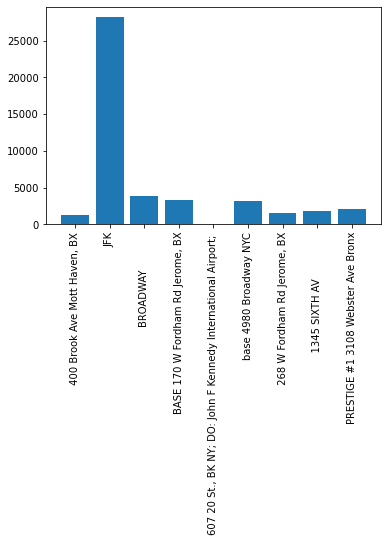

In [58]:
import matplotlib.pyplot as plt

names = list(most_freq_dict.keys())
values = list(most_freq_dict.values())
plt.bar(range(len(most_freq_dict)), values, tick_label=names)

plt.xticks(rotation=90)
plt.show()

## Prepration for Scalability

In [76]:
def bigger_data_frame(any_data_frame, nbr):
    tmp = any_data_frame
    print(tmp.count())
    for i in range(nbr-1):
        tmp = tmp.union(any_data_frame)
    print(tmp.count())
    return tmp

In [77]:
scale_2 = bigger_data_frame(uber_raw_data_read_test, 2)

4534327
9068654


In [79]:
if server_mode:
    path = 'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data'
else:
    path = os.getcwd() + '/DATA/'

scale_2_file = path+"scale_2.parquet"
scale_2.write.mode("overwrite").parquet(scale_2_file)

In [78]:
scale_3 = bigger_data_frame(uber_raw_data_read_test, 3)

4534327
13602981


In [80]:
if server_mode:
    path = 'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data'
else:
    path = os.getcwd() + '/DATA/'

scale_3_file = path+"scale_3.parquet"
uber_raw_data.write.mode("overwrite").parquet(scale_3_file)

In [81]:
sc.stop()
print("Spark closed!")

Spark closed!
